The goal of this notebook is to do two things. 

1) Construct Bellman Sampling
2) Focus on visualizing

## Quadrant Sampling
We will split the network into quadrants and sample the nodes from each quardrant to ensure we have nodes scattered throughout Cambridge. 

In [1]:
# importing the packages
import pandas as pd
import googlemaps
import time
import pandas as pd
import numpy as np
import pickle
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt

In [279]:
# loading in the data
with open("H_new_graph_2.pkl", 'rb') as f:
    H = pickle.load(f)

cambridge_crime = pd.read_csv("cambridge_crime_with_nodes_final.csv")
distance_matrix = pd.read_csv("distance_matrix_1880.csv", index_col = 0)
nodes_id = list(set(cambridge_crime['closest_node']))
nodes_id_cleaned = [str(id) for id in list(nodes_id)]
cleaned_distance_matrix =  distance_matrix.loc[nodes_id,nodes_id_cleaned]
# 1. Create the first DataFrame: node vs. crime count
# Count the number of crimes mapped to each node
node_crime_counts = cambridge_crime['closest_node'].value_counts().reset_index()
node_crime_counts.columns = ['node_id', 'crime_count']
# fig, ax = ox.plot_graph(H, node_size=5, edge_linewidth=0.5)

In [280]:
# dividing the nodes into quadrants
# extracting the latitude and the longitudes from each node along other things
# have info about highway, and info like this
# also filter out the nodes to match the ones we have oin our distance matrix
node_positions = {node: H.nodes[node] for node in [id for id in nodes_id if id in [node for node in H.nodes]]}
node_positions_df = pd.DataFrame.from_dict(node_positions, orient='index')[['lat', 'lon']]
node_positions_df.index.name = 'node_id'
node_positions_df.reset_index(inplace=True)
# node_positions_df

In [281]:
# merge the crime counts with the positions
node_data = pd.merge(node_positions_df, node_crime_counts, how='left', left_on='node_id', right_on='node_id')
# node_data

In [282]:
# Define quadrants based on median latitude and longitude
lat_median = node_data['lat'].median()
lon_median = node_data['lon'].median()

In [283]:
# Assign each node to a quadrant
# how we assign to a quadrant
node_data['quadrant'] = (node_data['lat'] > lat_median).astype(int) * 2 + (node_data['lon'] > lon_median).astype(int)
node_data['quadrant'].value_counts()

quadrant
1    561
2    561
0     80
3     79
Name: count, dtype: int64

In [284]:
# visualize the network with the quadrants 
# assign colors to the qudrants
quadrant_colors = {0:'red', 1:'blue', 2:'green',3:'yellow'}
node_data['color'] = node_data['quadrant'].map(quadrant_colors)
node_color_mapping = node_data.set_index('node_id')['color'].to_dict()

In [285]:
# try filtering the original graph
filtered_H = H.subgraph(node_positions).copy()

In [286]:
for node in filtered_H.nodes:
    filtered_H.nodes[node]['color'] = node_color_mapping[node]

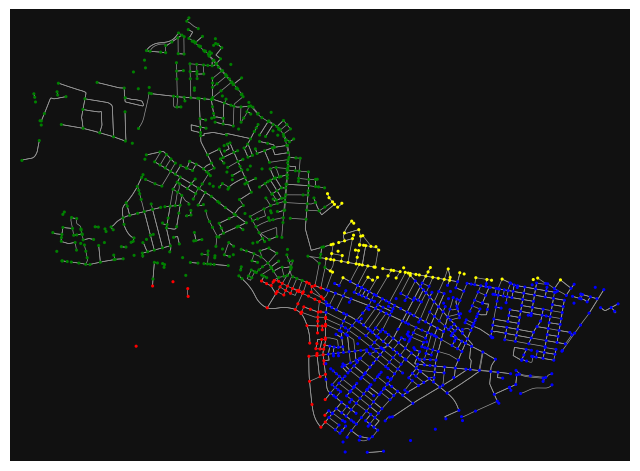

In [287]:
fig, ax = ox.plot_graph(
    filtered_H,
    node_size=5,
    edge_linewidth=0.5,
    node_color=[filtered_H.nodes[node]['color'] for node in filtered_H.nodes]
)

In [301]:
# we will write a function to use multiple times to resemble the network structure
def quadrant_down_sample(total_nodes):
    '''
    This is the function that we will use to downsample and visualize. 
    Parameters:

    Parameters: The number of total nodes that you want to keep
    Returns: All of the new dataframes we need for the optimization problem
    '''
    # print out the original distribution of the nodes 
    quadrant_counts_original = node_data['quadrant'].value_counts()

    # some retarded code I wrote to ensure it acutally adds up to nodes_keep
    # def redundant but who gives a fuck 
    proportional_allocation = (
    quadrant_counts_original / quadrant_counts_original.sum() * total_nodes
    ).astype(int)
    if proportional_allocation.sum() < total_nodes:
        diff = total_nodes - proportional_allocation.sum()
        if diff % 2 == 0:
            amount_to_assign = diff / 2
            proportional_allocation.values[2] += amount_to_assign
            proportional_allocation.values[3] += amount_to_assign
        else:
            proportional_allocation.values[2] += diff 

    # now the downsampling occurs
    # now we actualy downsample
    downsampled_node_data = pd.DataFrame()

    # we then need to make our graph smaller 

    # we will do this randomly
    for quadrant, group in node_data.groupby('quadrant'):
        # grab the proportional size 
        allocated_size = proportional_allocation[quadrant]
        if len(group) > allocated_size:
            # this is where we downsample
            downsampled_group = group.sample(n=allocated_size)
        else:
            downsampled_group = group
        
        downsampled_node_data = pd.concat([downsampled_node_data, downsampled_group], axis =0)
    
    # we have to remake our graph now 
    new_nodes = {node: filtered_H.nodes[node] for node in [id for id in downsampled_node_data['node_id']]}
    new_graph = filtered_H.subgraph(new_nodes).copy()


    # now we need to remake the cambridge_crimes data set 
    # Extract the latitudes and longitudes of the crime locations
    crime_latitudes = cambridge_crime['latitude']
    crime_longitudes = cambridge_crime['longitude']

    # Find the nearest nodes in the graph for each crime location
    crime_closest_nodes = ox.distance.nearest_nodes(new_graph, X=crime_longitudes, Y=crime_latitudes, return_dist=False)

    # Add the closest node as a new column in the crime DataFrame
    cambridge_crime['new_closest_node'] = crime_closest_nodes

    # 1. Create the first DataFrame: node vs. crime count
    # Count the number of crimes mapped to each node
    node_crime_counts = cambridge_crime['new_closest_node'].value_counts().reset_index()
    node_crime_counts.columns = ['node_id', 'crime_count']

    # now we need to filter through the distance matrix and just return this one
    nodes_id = list(set(cambridge_crime['new_closest_node']))
    nodes_id_cleaned = [str(id) for id in list(nodes_id)]
    new_cleaned_distance_matrix =  cleaned_distance_matrix.loc[nodes_id,nodes_id_cleaned]

    # Display the node-crime count DataFrame
    # print("Node-Crime Count DataFrame:")
    # print(node_crime_counts.head())

    # 2. Create the second DataFrame: add closest node to cambridge_crime DataFrame
    # The 'closest_node' column in cambridge_crime already contains this information

    # Display the updated cambridge_crime DataFrame
    # print("Updated Cambridge Crime DataFrame with Closest Node:")
    # print(cambridge_crime.head())
    # node_crime_counts.to_csv("/Users/anderssteiness/Desktop/MIT/MBAn/optimization/Project/node_crime_counts.csv", index=False)

    # cambridge_crime.to_csv("/Users/anderssteiness/Desktop/MIT/MBAn/optimization/Project/cambridge_crime_with_nodes.csv", index=False)
        
    return downsampled_node_data, cambridge_crime, node_crime_counts, new_cleaned_distance_matrix

In [308]:
new_node_data, new_cambridge_crime, new_crime_counts, new_distance_matrix =  quadrant_down_sample(400)

# Candidate Set Graph

In [7]:
# loading in the data
with open("/Users/anderssteiness/Desktop/MIT/MBAn/optimization/Project/subgraph/downsampled_subgraph_900.pkl", 'rb') as f:
    H = pickle.load(f)

node_data = pd.read_csv("/Users/anderssteiness/Desktop/MIT/MBAn/optimization/Project/subgraph/down_sampled_node_data_900.csv")
original_candidate = pd.read_csv("/Users/anderssteiness/Desktop/MIT/MBAn/optimization/Project/subgraph/candidate_nodes_900.csv")
distance_matrix = pd.read_csv("distance_matrix_1880.csv", index_col = 0)
distance_matrix.fillna(0, inplace = True)

In [10]:
node_data

,y,x,highway,street_count,lon,lat,color,geometry,cluster,node_id,crime_count
0,42.393518,-71.133103,NaN,3,-71.133103,42.393518,green,POINT (-71.1331031 42.393517599999996),0,61321129,65
1,42.397824,-71.130635,NaN,3,-71.130635,42.397824,green,POINT (-71.1306347 42.3978242),0,61317611,5
2,42.394692,-71.127119,traffic_signals,3,-71.127119,42.394692,green,POINT (-71.1271189 42.394692),0,61317543,15
3,42.392618,-71.127553,NaN,4,-71.127553,42.392618,green,POINT (-71.1275534 42.3926185),0,61321823,2
4,42.392979,-71.129020,NaN,4,-71.129020,42.392979,green,POINT (-71.12902 42.39297929999999),0,61333815,108
...,...,...,...,...,...,...,...,...,...,...,...
887,42.360245,-71.100972,NaN,3,-71.100972,42.360245,blue,POINT (-71.1009716 42.36024489999999),19,61322373,72
888,42.365289,-71.099984,NaN,1,-71.099984,42.365289,blue,POINT (-71.099984 42.36528899999998),19,61317513,6
889,42.366822,-71.097297,NaN,3,-71.097297,42.366822,blue,POINT (-71.0972971 42.3668222),19,61327190,8
890,42.357477,-71.092682,NaN,3,-71.092682,42.357477,blue,POINT (-71.0926819 42.357477300000006),19,11749290935,23


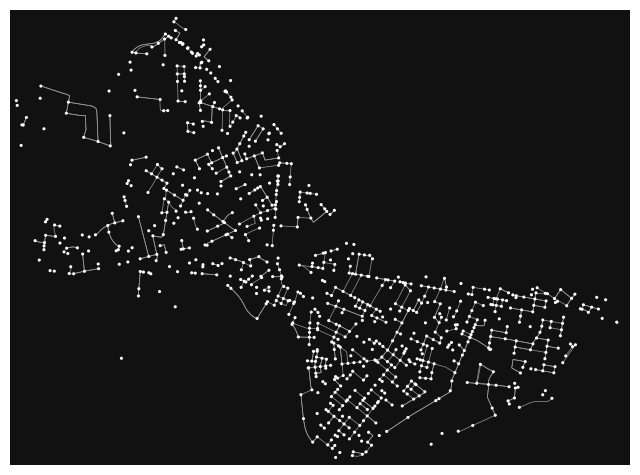

In [3]:

fig, ax = ox.plot_graph(
    H,
    node_size=5,
    edge_linewidth=0.5,
)

In [1]:
H

NameError: name 'H' is not defined

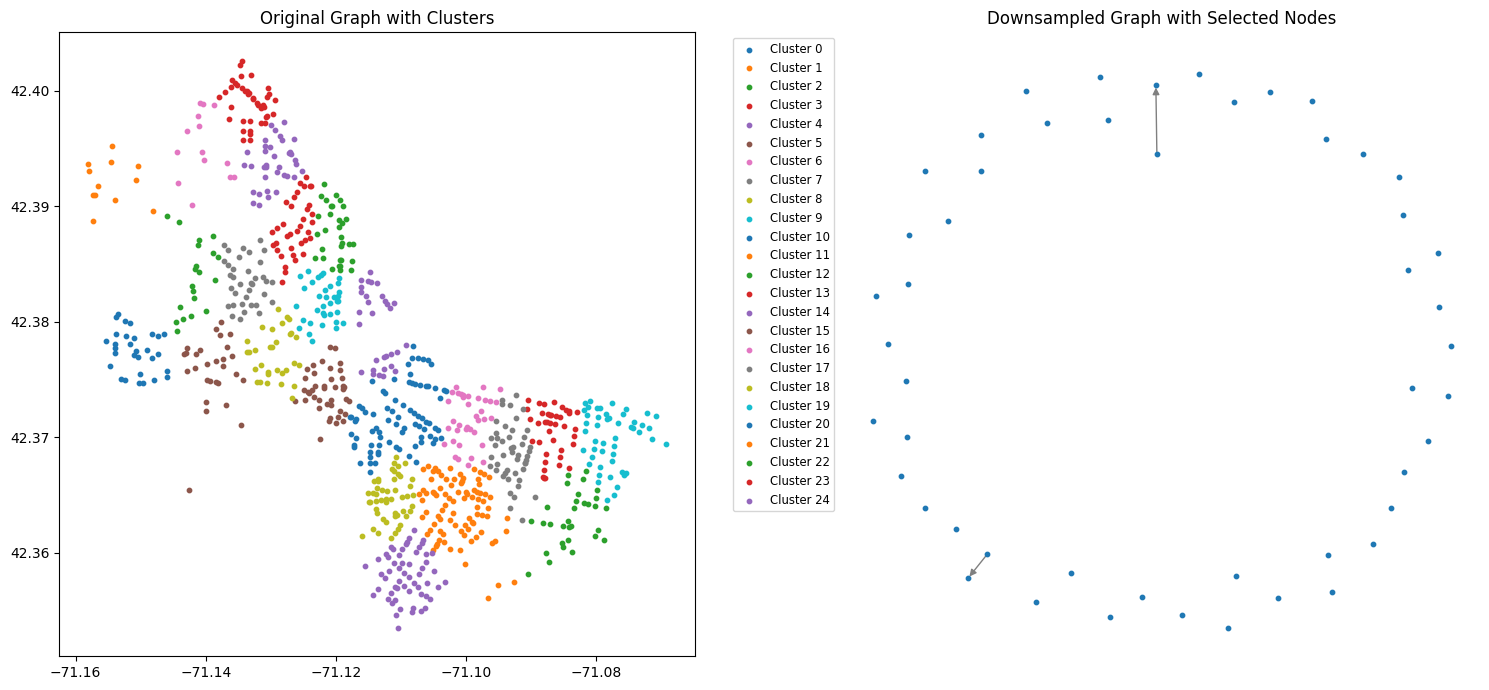

In [6]:
import random
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Extract longitude and latitude from graph nodes
coordinates = np.array([[data['x'], data['y']] for _, data in H.nodes(data=True)])

# Perform k-means clustering with 25 clusters and 100 initialization points
kmeans = KMeans(n_clusters=25, n_init=100, random_state=42)
kmeans.fit(coordinates)
labels = kmeans.labels_

# Create a mapping of cluster labels to node IDs
clusters = {i: [] for i in range(25)}
for i, label in enumerate(labels):
    clusters[label].append(list(H.nodes)[i])

# Select two random nodes per cluster
selected_nodes = []
for cluster_nodes in clusters.values():
    selected_nodes.extend(random.sample(cluster_nodes, min(2, len(cluster_nodes))))

# Create a new graph with only the selected nodes
downsampled_graph = H.subgraph(selected_nodes)

# Plot the original graph with clusters
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
for label in range(25):
    cluster_coords = coordinates[labels == label]
    ax[0].scatter(cluster_coords[:, 0], cluster_coords[:, 1], label=f"Cluster {label}", s=10)
ax[0].set_title("Original Graph with Clusters")
ax[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

# Plot the downsampled graph
nx.draw(downsampled_graph, ax=ax[1], node_size=10, edge_color="gray")
ax[1].set_title("Downsampled Graph with Selected Nodes")
plt.tight_layout()
plt.show()


             y          x          highway  street_count        lon  \
4    42.392979 -71.129020              NaN             4 -71.129020   
18   42.397044 -71.129918              NaN             3 -71.129918   
38   42.393048 -71.125267              NaN             3 -71.125267   
53   42.370132 -71.105494              NaN             3 -71.105494   
65   42.374241 -71.104753  traffic_signals             3 -71.104753   
55   42.368190 -71.099239              NaN             3 -71.099239   
99   42.367019 -71.076078              NaN             3 -71.076078   
107  42.370813 -71.074350              NaN             3 -71.074350   
115  42.369946 -71.077094              NaN             3 -71.077094   
170  42.372052 -71.114234              NaN             3 -71.114234   
171  42.371844 -71.107394              NaN             3 -71.107394   
139  42.374711 -71.108340              NaN             3 -71.108340   
185  42.374929 -71.134232              NaN             3 -71.134232   
214  4

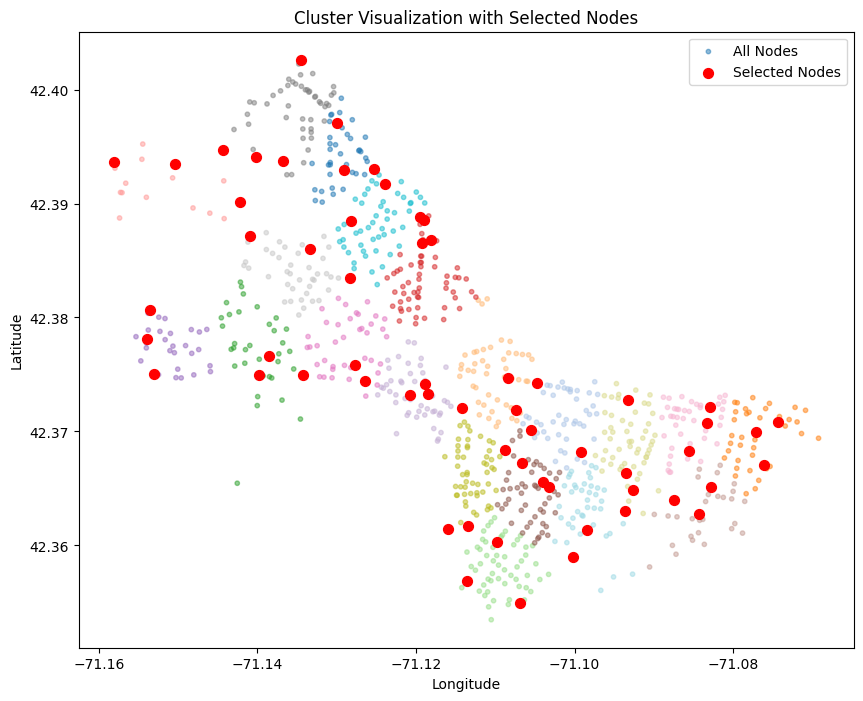

In [19]:
import pandas as pd

# Assuming node_data is your DataFrame
# Sort by 'cluster' and 'crime_count' in descending order
node_data_sorted = node_data.sort_values(by=['cluster', 'crime_count'], ascending=[True, False])

# Group by 'cluster' and select the top 2 nodes with the highest crime count in each cluster
top_nodes = node_data_sorted.groupby('cluster').head(3)

# Print or use the result
print(top_nodes)

# Optional: Extract the selected node IDs
selected_node_ids = top_nodes['node_id'].tolist()

# Plot the clusters with selected nodes
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 8))
# Plot all nodes in the dataset
plt.scatter(node_data['lon'], node_data['lat'], c=node_data['cluster'], cmap='tab20', s=10, alpha=0.5, label='All Nodes')
# Highlight selected nodes
selected_nodes = node_data[node_data['node_id'].isin(selected_node_ids)]
plt.scatter(selected_nodes['lon'], selected_nodes['lat'], c='red', s=50, label='Selected Nodes')
plt.title("Cluster Visualization with Selected Nodes")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.show()


In [16]:
original_candidate

,node_id,x,y,crime_count,cluster
0,1421366892,-71.140207,42.394042,203,0
1,61318572,-71.093634,42.362977,138,1
2,6124468256,-71.120710,42.373229,313,2
3,4173900794,-71.142177,42.390099,489,3
4,11679014095,-71.076078,42.367019,535,4
5,61329987,-71.128163,42.388466,176,5
6,61317361,-71.108771,42.368390,237,6
7,61326941,-71.105494,42.370132,217,7
8,61329055,-71.134232,42.374929,138,8
9,61329647,-71.109786,42.360282,131,9


In [24]:
# Sort by 'cluster' and 'crime_count' in descending order
node_data_sorted = node_data.sort_values(by=['cluster', 'crime_count'], ascending=[True, False])

# Group by 'cluster' and select the top 2 nodes with the highest crime count in each cluster
top_nodes = node_data_sorted.groupby('cluster').head(3)
# Select only the required columns
selected_candidates = top_nodes[['node_id', 'lon', 'lat', 'crime_count', 'cluster']].copy()

# Rename columns to match the desired format
selected_candidates.rename(columns={'lon': 'x', 'lat': 'y'}, inplace=True)

# Display the result
selected_candidates
selected_candidates.to_csv("/Users/anderssteiness/Desktop/MIT/MBAn/optimization/Project/subgraph/candidate_nodes_900_60.csv", index=False)


In [25]:
t = pd.read_csv("/Users/anderssteiness/Desktop/MIT/MBAn/optimization/Project/subgraph/candidate_nodes_900_60.csv")
t

,node_id,x,y,crime_count,cluster
0,61333815,-71.129020,42.392979,108,0
1,61332465,-71.129918,42.397044,103,0
2,61332151,-71.125267,42.393048,84,0
3,61326941,-71.105494,42.370132,217,1
4,61321023,-71.104753,42.374241,185,1
5,61321943,-71.099239,42.368190,173,1
6,11679014095,-71.076078,42.367019,535,2
7,9634533325,-71.074350,42.370813,166,2
8,61326713,-71.077094,42.369946,102,2
9,61325420,-71.114234,42.372052,148,3


# Vizualization

In [14]:
61317423 in set(H.nodes())

True

In [25]:
distance_matrix.loc[61323288,"61323288"]

0.0

Police Station 61323288 covers nodes: {61318150, 1400112148, 61317653, 61323284, 61323288, 2559968283, 2562504738, 61321765, 2562504741, 61323306, 2559968299, 2559968298, 2559968311, 2559968314, 61322299, 61329988, 61327432, 61330009, 61330013, 61322845, 61330016, 61322849, 61322856, 61330026, 12138790517, 61317759, 61330577, 61322390, 61321367, 61327517, 61323436, 61322935, 61332151, 61330128, 61322963, 2562522840, 61322981, 3306934506, 7980904724, 61320982, 61318428, 61318430, 61318431, 61330207, 61330217, 61321515, 61318448, 61318449, 61317428, 61321524, 5176457017, 2562494269, 2562494270, 61323077, 61318474, 61318475, 61318481, 9070681939, 61323115, 61330284, 61327730, 61321083, 61318538, 61318539, 61328279, 61323173, 61322149, 9907930023, 61322154, 61322158, 61318065, 61333938, 61322162, 61322177, 61322180, 61322186, 61330378, 2562497994, 61323220, 61323222, 61323735, 1078210009, 61323229, 61323233, 61323750, 61323765}
Police Station 61317423 covers nodes: {9973710848, 61321218, 6

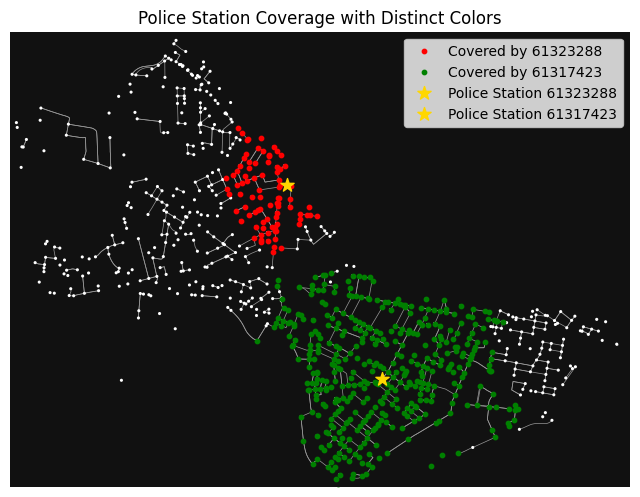

In [36]:
distance_matrix.index = distance_matrix.index.astype(int)
distance_matrix.columns = distance_matrix.columns.astype(int)

police_stations = {
    61323288: 1000,  # Node ID: coverage radius in meters
    61317423: 2000
}

# Filter nodes to only those present in H
H_nodes = set(H.nodes)

# Identify nodes covered by each police station
station_coverage = {}  # Dictionary to hold nodes covered by each police station
for station, radius in police_stations.items():
    if station in H_nodes:  # Only process police stations present in H
        # Get nodes within the coverage radius and intersect with H's nodes
        within_radius = distance_matrix.loc[station][distance_matrix.loc[station] <= radius].index
        station_coverage[station] = {node for node in within_radius if node in H_nodes}

        # Debugging: Print the nodes within the radius for each station
        print(f"Police Station {station} covers nodes: {station_coverage[station]}")

# Plotting
fig, ax = ox.plot_graph(
    H,
    node_size=5,
    edge_linewidth=0.5,
    show=False,
    close=False,
)

# Extract node coordinates from H
node_positions = {node: (data['x'], data['y']) for node, data in H.nodes(data=True)}

# Define colors for each police station's coverage
colors = ["red", "green", "orange", "purple", "cyan"]  # Add more if needed
color_map = {station: colors[i] for i, station in enumerate(police_stations)}

# Plot nodes within coverage radius with unique colors
for station, nodes in station_coverage.items():
    for node in nodes:
        if node in node_positions:  # Ensure node exists in H
            x, y = node_positions[node]
            ax.scatter(x, y, color=color_map[station], s=10, label=f"Covered by {station}" if f"Covered by {station}" not in ax.get_legend_handles_labels()[1] else "")

# Mark police stations with a special symbol (e.g., star, larger size)
for station in police_stations:
    if station in H_nodes:  # Only plot stations present in H
        x, y = node_positions[station]
        ax.scatter(x, y, color="gold", marker="*", s=100, label=f"Police Station {station}")

# Final adjustments
ax.legend()
plt.title("Police Station Coverage with Distinct Colors")
plt.show()